In [1]:
import re, os
import shutil
import pickle
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ROOT_FOLDER = "/mnt/hgfs/projlogs/SFW/sops1/SOPS/Performance Test - Performance_Test1"
ROOT_FOLDER = "/mnt/hgfs/projlogs/SFW/hq1/Performance Test - Performance_Test1"
# MILL, POND, OPP1, OPP2, FOX
# SOPS, HQ1, BAYVIEW, FIELD1
ROOT_FOLDER = "/mnt/hgfs/projlogs/SFW/SOPS"

In [2]:
class TestError():

    def __init__(self, timestamp, userid, cycleid, uj, stepid, errortype, message, test_folder):
        self.time = pd.to_datetime(timestamp, infer_datetime_format=True) 
        self.userid = userid
        self.cycleid = cycleid
        self.stepid = stepid
        self.errortype = errortype
        self.message = message
        self.test_folder = test_folder
        self.uj = uj
        
        self.cause = ''
        self.cause_message = ''
        
        if errortype == 'Success Validation Failure':
            sv = re.search(r'failed sub validations: (.+?)\) for step ".+?" was not found in the response. The response received has been written to "(.+?)"', message)
            self.validation = sv.group(1)
            self.file = sv.group(2)
            # name_parts = self.file.split('__')
            # self.uj = name_parts[0]
        else:
            self.validation = None
            self.file = None

        if errortype == 'Response DD Extraction Failure':
            ddisrc = re.search(r'Error reading value for response DD item (.+?) used in step (.+?)', message)
            self.dditem = ddisrc.group(1)
            # !!! the line below currently gives wrong value due to BUG in the ST logs.
            # self.ddi_source = ddisrc.group(2)
        else:
            self.dditem = None
    
    def show(self, shorten=True):
        if shorten:
            message = self.cause_message[:50] + (len(self.cause_message)>50)*'...'
        if self.dditem:
            message = self.dditem
        return OrderedDict([('time', self.time),
                ('user', self.userid),
#                 ('total errors', 0),
                ('uj', self.uj),
                ('step', self.stepid),
                ('cycle', self.cycleid),
                ('error type', self.errortype),
                ('error cause', self.cause),
                ('cause message/ddi', message),
               ])
    
    def set_snapshot_details(self):
        pass
        
    def _read_error_file(self):
        if self.errortype == 'Success Validation Failure':
            try:
                # for QR, log files are directly in the log folder for the run
                with open(os.path.join(self.test_folder, self.file), 'rt') as f:
                    html = f.read()
            except FileNotFoundError:
                # for non-QR, log files are in subfolders named after virtual user ids
                with open(os.path.join(self.test_folder, 'user'+self.userid , self.file), 'rt') as f:
                    html = f.read()

        return html
    
    def _set_cause(self, cause, message):
        self.cause = cause
        self.cause_message = message
        
    def determine_casuse(self):
        if self.errortype == 'Success Validation Failure':
            html = self._read_error_file()
            if html.count('<label for="username">User Name:</label>')>0:
                self._set_cause('logged off', '')
                return None

            kick_match = re.search(r'redirect><\!\[CDATA\[https*://.+?/maximo/webclient/login/logout.jsp.*?\]\]></redirect>', html)
            if kick_match is not None:
                self._set_cause('Maximo forcefully signed out the user', '')
                return None

            if html.count('title="Please wait...">Please wait...</label>')>0:
                self._set_cause('Long Op', '')
                return None
            
            if html.count("addLongOpTimeout('dolongopquerycheck()',")>0:
                self._set_cause('Long Op', '')
                return None

            if html.count('MessageWarning.png')>0:
                msg = html[html.find('MessageWarning.png'):]
                msg = '<' + msg[:msg.find('</table>')]
                msg = re.sub(r'<[^>]*?>', '', msg)
                msg = msg.replace('\n','').strip()
                self._set_cause('Warning Message', msg)
                return None

            if html.count('st_MessageQuestion.png')>0:
                msg = html[html.find('st_MessageQuestion.png'):]
                msg = '<' + msg[:msg.find('</table>')]
                msg = re.sub(r'<[^>]*?>', '', msg)
                msg = msg.replace('\n','').strip()
                self._set_cause('Question Message', msg)
                return None
            
            if html.count('st_MessageCritical.png')>0:
                msg = html[html.find('st_MessageCritical.png'):]
                msg = '<' + msg[:msg.find('</table>')]
                msg = msg[:msg.find('</component>')]                
                msg = re.sub(r'<[^>]*?>', '', msg)
                msg = msg.replace('\n','').strip()
                self._set_cause('Critical Message', msg)
                return None

            if html.count('>0 - 0 of 0')>0:
                self._set_cause('operation resulted in a table with zero rows', 'searchterm: ' + self.validation)
                return None

            break_index = html.find('---------------Response-----------------')
            html_request_only = html[:break_index]
            html_response_only = html[break_index + 40:]
            if html_response_only.count(self.validation)>0:
                self._set_cause('validation bug', 'searchterm: ' + self.validation)
                return None

            ###  --- COB specific errors ---
            if  html_response_only.count('"id":"0_APPRSS_OPTION","text":"APPRSS"') and not html_response_only.count('Approved'):
                self._set_cause('missing "Approved" option', '')
                return None

            if html_request_only.count('targetId%22%3A%22mx387') and html_response_only.count('title="1 - 2 of 2">1 - 2'):
                self._set_cause('dynamic response', 'missing reference of WO field, thus cant validate')
                return None

            if html_request_only.count('<command>ISWM-RECORDFAILUREREPORT</command>'):
                self._set_cause('response lacks confirmation of recordid', 'response lacks confirmation of recordid')
                return None   
            ### --- ==================== ---

            self._set_cause('unknown validation fail', html)
            self.html = html
        else:
            self._set_cause(self.errortype, '')


In [3]:
class Loop():
    
    def __init__(self, lead_error, lenght):
        # the start & end index, should refer to cycle index, not error index
        self.lead_error = lead_error
        self.start = int(lead_error.cycleid)
        self.end = self.start + lenght
        # the +1 is needed because both the starter and the final cycles are part of the loop
        # it shouldn't be passed in the constructor in order to properly calculate the end cycle id
        self.lenght = lenght + 1
        
    def show(self):
        return OrderedDict([('loop start', self.start), ('loop length', self.lenght),])
    
    def __repr__(self):
        return str(self.start) + '-' + str(self.end)

In [4]:
class VirtualUser():
    
    def __init__(self, userid, start_time, uj, errors=[], loops=[], max_loop=None):
        self.userid = userid
        self.start_time = start_time
        self.uj = uj
        self.errors = errors
        self.loops = loops
        self.max_loop = max_loop
        
    # If I can user.errors.append(err) , why create a method?
    def append_error(self, error):
        self.errors.append(error)

    def process_errors(self):
        self.error_count = len(self.errors)
        
        consecutive_count = 0
        consecutiveness = ''
        max_consecutive = -1
        max_loop = -1
        # looping over errors in reverse, thus init with values of the last error in the list
        prior_error = self.errors[-1]
        for error in reversed(self.errors):
            error.determine_casuse()

            # the 1st condition needs <= instead of == because there could be multiple errors per cycleid
            # the 2nd condoition is to avoid counting the initial record as a consecutive term
            if int(prior_error.cycleid) - int(error.cycleid) <= 1 and error != self.errors[-1]:
                consecutive_count += 1
            else:
                if consecutive_count > 0:
                    new_loop = Loop(prior_error, consecutive_count)
                    self.loops.append(new_loop)
                    consecutiveness = ';' + str(new_loop) + consecutiveness

                    # update max_loop
                    if consecutive_count > max_consecutive:
                        max_consecutive = consecutive_count
                        self.max_loop = new_loop

                consecutive_count = 0
                
            prior_error = error
        
        # check if the for-ending error was completing an error-loop
        if consecutive_count > 0:
            new_loop = Loop(prior_error, consecutive_count)
            self.loops.append(new_loop)
            consecutiveness = ';' + str(new_loop) + consecutiveness

            # update max_loop
            if consecutive_count > max_consecutive:
                max_consecutive = consecutive_count
                self.max_loop = new_loop
        
        self._process_cause_stats()
        
        return consecutiveness[1:]
    
    def _process_cause_stats(self):
        causes = {}
        for e in self.errors:
            if e.cause in causes.keys():
                causes[e.cause] += 1
            else:
                causes[e.cause] = 1

        self.causes = causes
        
    def lead_error_info(self):
        # return info on the "lead" error of the longest error-loop
        #   or the first error for the user
        
        if self.max_loop:
            lead_error_info = self.max_loop.lead_error.show()
            max_loop_info = self.max_loop.show()
        else:
            lead_error_info = self.errors[0].show()
            max_loop_info = OrderedDict([('loop start', ''), ('loop length', '')])
            
        def surgery(ordered_dict, index, insertion):
            return OrderedDict(list(ordered_dict.items())[:index] + 
                               list(insertion.items()) + 
                               list(ordered_dict.items())[index+1:])
        
        lead_error_info = surgery(lead_error_info, 2, {'total errors': user.error_count})
        lead_error_info = surgery(lead_error_info, -2, max_loop_info)
            
#         lead_error_info['total errors'] = user.error_count
        return lead_error_info
    
    def show_errors(self):
        return pd.DataFrame([ z.show() for z in self.errors ])
    
    def plot_user_errors(self, period='h'):
        if isinstance(period, str):
            # period = TIME_CODES[period]
            period = {'h': lambda x: x.hour, 'm': lambda x: x.minute}[period]
#         as_np_array = np.array([ list(z.show().values()) for z in vusers[user].errors ])
        user_df = self.show_errors()
        user_df["time"] = pd.to_datetime(user_df["time"])
        per_hr = user_df.groupby(user_df['time'].apply(period)).user.count()
        per_hr.plot('bar', color='b');


Determine the number of relevant log files in the log's Run folder.

In [5]:
test_folder = ROOT_FOLDER

## Considered running simultaneous analisys of different injectors:
##    it will not work, because user ids are repeated i.e user 0006 on INJ1 will be assigned to UJ1,
##    while user 0006 on INJ2 will have different UJ, and different errors, and etc.

files = [ f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder,f)) and f.find('.log.')>0 ]
files = [ f for f in files if f.find('lck')==-1 ]
print('at', test_folder, ', found', len(files), 'log files: ', files)

at /mnt/hgfs/projlogs/SFW/SOPS , found 1 log files:  ['SOPS2UA5101XHD_0.log.1']


In case of multiple log files, merge them and work with the merged file.

In [6]:
if len(files)==1:
    FNAME = files[0]
elif len(files)>1:
    print('multiple files - merging into _log.all')
    FNAME = '_log.all'
    with open(os.path.join(test_folder, FNAME), 'wb') as wfd:
        for file in files:
            with open(os.path.join(test_folder, file),'rb') as fd:
                shutil.copyfileobj(fd, wfd, 1024*1024*100)
                #100MB per writing chunk to avoid reading big file into memory.

else:
    if not FNAME:
        print('no files found - please assign FNAME manually')
        exit(1)
    

Obtain the list of errors.

In [7]:
print('processing file: ', test_folder + '/' + FNAME)

with open(test_folder + '/' + FNAME,'r') as f:
    alllog = f.read()

errorlog = re.findall(r'(?<=\n).+?\[SEVERE\].+?id \d+?,[\w\s]+?\):.+?(?=\n)', alllog)
print('severe count:', len(errorlog))

processing file:  /mnt/hgfs/projlogs/SFW/SOPS/SOPS2UA5101XHD_0.log.1
severe count: 6938


Obtain the list of snapshots.

In [8]:
snap = r'<GENERAL_DATA>\n\s+?<APPLICATION>([^<]+?)</APPLICATION>\n\s+?<USER_JOURNEY>([^<]+?)</USER_JOURNEY>\n\s+?<STEP>([^<]+?)</STEP>\n\s+?<ERROR>([^<]+?)</ERROR>\n\s+?<INJECTOR_NAME>([^<]+?)</INJECTOR_NAME>\n\s+?<START_DATE>([^<]+?)</START_DATE>\n\s+?<RUN_NAME>([^<]+?)</RUN_NAME>\n\s+?<BROWSER_PROFILE>([^<]+?)</BROWSER_PROFILE>\n\s+?<DATE>([^<]+?)</DATE>\n\s+?<PROCESS_NAME>([^<]+?)</PROCESS_NAME>\n\s+?<PROCESS_NUMBER>([^<]+?)</PROCESS_NUMBER>\n\s+?<USER_ID>([^<]+?)</USER_ID>\n\s+?<CYCLE_ID>([^<]+?)</CYCLE_ID>\n\s+?<CURRENT_USERS>([^<]+?)</CURRENT_USERS>\n\s+?<CURRENT_CONNECTIONS>([^<]+?)</CURRENT_CONNECTIONS>\n\s+?</GENERAL_DATA>'

snaplog = re.findall(snap, alllog)
print('snapshots:', len(snaplog))

snapshots: 7983


In [9]:
# # Dump the snapshot list into a debug file
# with open(os.path.join(test_folder, 'snaps.dump.txt'), 'wt') as f:
#     f.write('\n'.join(map(str, snaplog)))

Parse the log file and create User and Error objects

In [10]:
errors = []
vusers = {}
for err in errorlog:
    time = err[:20]
    usr = re.search(r'user.(\d+?),.cycle', err)
    user = usr.group(1)
    user = str(user).rjust(4,'0')
    cyc = re.search(r'cycle.(\d+?),.step', err)
    cycle = cyc.group(1)
    stp = re.search(r'step\s+?(.+?),\s+?id', err)
    step = stp.group(1)
    errtype = re.search(r', status (.+?)\)', err)
    error_type = errtype.group(1)
    message = err[err.find('):'):]
    
    uj = ''
    try:
        # find matching snapshot by user and cycle -- will fail in case of 2 errs in 1 cycle
        uj = [ z[1] for z in snaplog if z[-4]==str(int(user)) and z[-3]==cycle ][0]
    except IndexError:
        print('failed to find snapshot data for user', user, 'cycle', cycle)
    
    new_error_record = TestError(time, user, cycle, uj, step, error_type, message, test_folder)
    errors.append(new_error_record)
    if user in vusers.keys():
        vusers[user].append_error(new_error_record)
    else:
        vusers[user] = VirtualUser(user, '', uj, [new_error_record])

print('errors:', len(errors), '; erroring_users:', len(vusers))
pickle.dump((errors, vusers), open(os.path.join(test_folder, 'errors_users.pickle'), 'wb' ))

errors: 6938 ; erroring_users: 13


In [11]:
# errors, vusers = pickle.load(open(os.path.join(test_folder, 'errors_users.pickle'), 'rb'))

In [12]:
sorted_keys = sorted(vusers.keys())
print('erroring users', len(sorted_keys))
for userid in sorted_keys:
    user = vusers[userid]
    consecutiveness = user.process_errors()
    print('\n','user', user.userid, 'has error count:', user.error_count,
          
          # these stats cannot be found in the log files, only in the DB
#           'and erroring cycles count of:', user.error_cyc_count,
#           'out of', user.cycles, 'total cycles'
         )
    
    if len(consecutiveness):
        print('~~ max error loop:: length', user.max_loop.lenght, 'start cycle:',
              user.max_loop.start, 'end cycle:', user.max_loop.end)
        print('~~', consecutiveness)

pickle.dump(vusers, open(os.path.join(test_folder, 'with_loops.pickle'), 'wb' ))

erroring users 13

 user 0000 has error count: 1586
~~ max error loop:: length 1584 start cycle: 199 end cycle: 1782
~~ 199-1782

 user 0001 has error count: 1568
~~ max error loop:: length 1563 start cycle: 201 end cycle: 1763
~~ 201-1763

 user 0002 has error count: 1571
~~ max error loop:: length 1567 start cycle: 201 end cycle: 1767
~~ 201-1767

 user 0006 has error count: 1

 user 0007 has error count: 2

 user 0008 has error count: 342
~~ max error loop:: length 321 start cycle: 197 end cycle: 517
~~ 172-173;180-181;185-194;197-517

 user 0009 has error count: 337
~~ max error loop:: length 321 start cycle: 196 end cycle: 516
~~ 177-178;182-183;186-190;196-516

 user 0010 has error count: 221
~~ max error loop:: length 220 start cycle: 149 end cycle: 368
~~ 149-368

 user 0011 has error count: 223
~~ max error loop:: length 223 start cycle: 145 end cycle: 367
~~ 145-367

 user 0012 has error count: 137
~~ max error loop:: length 98 start cycle: 96 end cycle: 193
~~ 22-23;25-28;30

In [13]:
# vusers = pickle.load(open(os.path.join(test_folder, 'with_loops.pickle'), 'rb'))

In [14]:
causes = {}
causes_keys = []
accu = []

for userid in sorted_keys:
    user = vusers[userid]
    
#     if user.max_loop:
#         lead_error_info = user.max_loop.lead_error.show()
#         lead_error_info['total errors'] = user.error_count
#         if user.max_loop.lead_error.errortype == 'Response DD Extraction Failure':
#             lead_error_info['cause message/ddi'] = user.max_loop.lead_error.dditem
    accu.append(list(user.lead_error_info().values()))
        
    if causes_keys == []:
        causes_keys = list(user.lead_error_info())
            
    
    # summation of values of corresponding key over list of dicts
    for key in user.causes.keys():
        causes[key]=causes.setdefault(key, 0) + user.causes[key]
    
print('count of erroring users:', len(sorted_keys))
for k,v in causes.items():
    print('cause', k, 'has count', v)

# OrderedDict([('time', self.time),
#                 ('user', self.userid),
#                 ('total user errors', 0),
#                 ('uj', self.uj),
#                 ('step', self.stepid),
#                 ('cycle', self.cycleid),
#                 ('error type', self.errortype),
#                 ('error cause', self.cause),
#                 ('cause message/ddi', self.cause_message),
#                ])

accu

# cols = ['time', 'user', 'total user errors', 'uj', 'cycle', 'error type',
#         'error cause', 'cause message',]

# accu = [ [ z[y] for y in cols ] for z in accu ]
    
data = pd.DataFrame(accu, columns=causes_keys)

count of erroring users: 13
cause 500 has count 4718
cause Critical Message has count 850
cause Response DD Extraction Failure has count 1045
cause unknown validation fail has count 23
cause Long Op has count 2
cause operation resulted in a table with zero rows has count 207
cause Warning Message has count 93


Info on the "lead" errors for the longest error-loop or, if no error-loop, the first error for the user:

In [15]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
data

,time,user,total errors,step,cycle,error type,loop start,loop length,cause message/ddi
0,2018-01-29 06:08:30,0000,1586,Select a WO,199,Response DD Extraction Failure,199,1584,Open and Change to COMP as Supervisor ID 4
1,2018-01-29 06:10:41,0001,1568,Select a WO,201,Response DD Extraction Failure,201,1563,Open and Change to COMP as Supervisor ID 4
2,2018-01-29 06:10:33,0002,1571,Select a WO,201,Response DD Extraction Failure,201,1567,Open and Change to COMP as Supervisor ID 4
3,2018-01-29 02:59:17,0006,1,Select WO,23,Response DD Extraction Failure,,,test journey ID 5
4,2018-01-29 06:08:35,0007,2,Find,76,Success Validation Failure,,,
5,2018-01-29 06:34:37,0008,342,Select WO,197,Response DD Extraction Failure,197,321,Open and Assign CM WO as Supervisor ID 3
6,2018-01-29 06:34:15,0009,337,Select WO,196,Response DD Extraction Failure,196,321,Open and Assign CM WO as Supervisor ID 3
7,2018-01-29 05:11:59,0010,221,Create WO,149,Success Validation Failure,149,220,BMXAA7837E - An error occured that prevented the G...
8,2018-01-29 05:05:01,0011,223,Create WO,145,Success Validation Failure,145,223,BMXAA7837E - An error occured that prevented the G...
9,2018-01-29 06:34:09,0012,137,Refer to,96,Success Validation Failure,96,98,"searchterm: value=""No Follow Up Action was Require..."


In [16]:
# # [ z.show() for z in vusers['0012'].errors ]
# errors12 = pd.DataFrame([ z.show() for z in vusers['0012'].errors ])
# errors12
vusers['0012'].show_errors()

,time,user,uj,step,cycle,error type,error cause,cause message/ddi
0,2018-01-29 02:51:13,0012,Open WO finding and FIELDCOMP,Change status_icon,19,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
1,2018-01-29 03:00:55,0012,Open WO finding and FIELDCOMP,Select Additional Findings,22,Success Validation Failure,Critical Message,BMXAA2256E - Field Additional Findings is read-onl...
2,2018-01-29 03:03:41,0012,Open WO finding and FIELDCOMP,Change status_icon,23,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
3,2018-01-29 03:09:28,0012,Open WO finding and FIELDCOMP,Change status_icon,25,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
4,2018-01-29 03:11:45,0012,Open WO finding and FIELDCOMP,Change status_icon,26,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
5,2018-01-29 03:13:40,0012,Open WO finding and FIELDCOMP,Remedy Lookup,27,Success Validation Failure,unknown validation fail,"<?xml version=""1.0"" encoding=""UTF-8"" ?>\n<server_re..."
6,2018-01-29 03:16:27,0012,Open WO finding and FIELDCOMP,Change status_icon,28,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
7,2018-01-29 03:22:30,0012,Open WO finding and FIELDCOMP,Change status_icon,30,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
8,2018-01-29 03:24:50,0012,Open WO finding and FIELDCOMP,Change status_icon,31,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...
9,2018-01-29 03:27:28,0012,Open WO finding and FIELDCOMP,Change status_icon,32,Success Validation Failure,Warning Message,BMXAA8229W - Record WORKORDER : Site=WW Work Orde...


In [17]:
#list(vusers['0011'].errors[0].show().keys())
list(vusers['0011'].errors[0].show())

['time',
 'user',
 'uj',
 'step',
 'cycle',
 'error type',
 'error cause',
 'cause message/ddi']

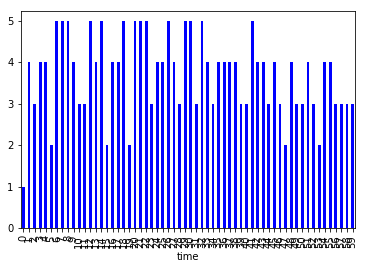

In [20]:
vusers['0011'].plot_user_errors('m')

---------------------------------------------------

In [19]:
FAIL HERE

SyntaxError: invalid syntax (<ipython-input-19-f2aac8727edc>, line 1)

In [ ]:
pd.Series.dt

In [ ]:
pd.Series.dt.hour

In [ ]:
as_np_array = np.array([ list(z.show().values()) for z in vusers['0011'].errors ])
user_df = pd.DataFrame(as_np_array, columns=list(vusers['0011'].errors[0].show()))

In [ ]:
user_df

In [ ]:
type(user_df.time)

In [ ]:
times = pd.to_datetime(user_df.time)
type(times)

In [ ]:
user_df.time.dtype

In [ ]:
user_df["time"] = pd.to_datetime(user_df["time"])

In [ ]:
user_df.time.dtype

In [ ]:
user_df["time"].dt

In [ ]:
period = 'm'
period = {'h': lambda x: x.hour, 'm': lambda x: x.minute}[period]
# as_np_array = np.array([ list(z.show().values()) for z in vusers[user].errors ])
# user_df = self.show_errors()
per_hr = user_df.groupby(user_df['time'].apply(period)).user.count()
per_hr

In [ ]:
per_hr.plot('bar', color='b');

In [ ]:
user_df["time"].apply(lambda x: x.hour)

In [ ]:
user_df.groupby([times.hour]).count()

In [ ]:
# per_hr = user_df.groupby(user_df['time'].dt.hour)
per_hr = user_df.groupby(user_df['time'].hour)

# times = pd.to_datetime(df.timestamp_col)
# df.groupby([times.hour, times.minute]).value_col.sum()

In [ ]:
def plot_user_errors(user):
    as_np_array = np.array([ list(z.show().values()) for z in vusers[user].errors ])
    user_df = pd.DataFrame(as_np_array, columns=list(vusers['0011'].errors[0].show()))
    per_hr = user_df.groupby(user_df['time'].dt.hour)
    per_hr['user'].count().plot('bar', color='b');

In [ ]:
plot_user_errors('0014')

In [ ]:
[ z.show() for z in vusers['0014'] ]

In [ ]:
plot_user_errors('0008')

In [ ]:
[ z.show() for z in vusers['0008'] ]

In [ ]:
plot_user_errors('0009')

status to COMP as Supervisor

In [ ]:
[ z.show() for z in vusers['0001'] ]

Open, edit a SR and Convert to WO

In [ ]:
plot_user_errors('0011')

In [ ]:
[ z.show() for z in vusers['0011'] ]